# Trustly Challenge

This is the exploratory notebook for the Trustly challenge dataset. Here are my tests and conclusions about model training process.

In [17]:
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np

pd.set_option('mode.chained_assignment', None)


%matplotlib inline

## Data ingestion


#### Some highlights about the data ingestion process:

1. The original dataset wasn't in the UTF-8 format. Needed to search for a correct encoding
2. I used the pandas_profiling package to explore columns properties. It will generate a output.html with descriptive information about each feature.
3. At first sight read_csv are reading the columns types correctly.


In [18]:
df = pd.read_csv('./datasets/dataset_test_ds_v2-Atualizado.csv',  encoding='latin-1')

In [19]:
df.head()

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,CEP,TARGET
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,0,SP,São Paulo,8412006,0
1,201910,0.0,4.4,35.00,1369,0.0,0,63.98,1.0,0.0,0,RJ,Rio de Janeiro,23580304,0
2,201906,0.0,0.7,52.99,1228,0.0,0,98.84,0.0,0.0,0,MG,Belo Horizonte,30421310,0
3,201910,0.0,63.3,810.00,0,0.0,1,9237.21,0.0,0.0,0,SP,São Paulo,8253410,0
4,201902,0.0,4.1,17.50,0,0.0,1,27.70,1.0,0.0,0,ES,Vitória,29017186,0


In [20]:
df.dtypes

SAFRA       int64
V1        float64
V2        float64
V3        float64
V4          int64
V5        float64
V6          int64
V7        float64
V8        float64
V9        float64
V10         int64
V11        object
V12        object
CEP         int64
TARGET      int64
dtype: object

#### Here goes a brief resume about the raw dataset from profiling. For charts and info, pelase, refer to output.html file.
   1. There are 15 columns, one of them named as target. 
   2. It is a small dataset. There are 11169 rows. No duplicated rows detected. 1.5% of cells with missing values.
   3. Safra column looks like a date in a YYYY-mm format. Range from 2019-01 to 2019-12
   4. Some categorical featues (V1, v3, target) are unbalanced, with far more occurrencies from um type than another
   5. V1, V6, V10 and Target are binnary categorical variables. NANs and values different from 0, 1 will be removed.
   6. V11 and V12 are Brazilian state and city information. They are well formated without typos or broken names.
   7. The cardinality of the labels is reduced as well. Only 4 states and 20 cities are present in the base.
   8. Data types:
       - Categorical : V1, V6, V8, V9, V10
       - Integer : V5
       - Positive Real : V2, V3, V4, V7
   9. Features V2 and V3 are strongly correlated with feature V7. It can bring collinearity effects in linear models and must be watched
   10. The dataset has NANs. The are present in ~20% of the rows and will be removed. 
   11. No +/-infs os other undefined values found
    

In [21]:
from pandas_profiling import ProfileReport

#EDA using pandas-profiling
profile = ProfileReport(df, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html");


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

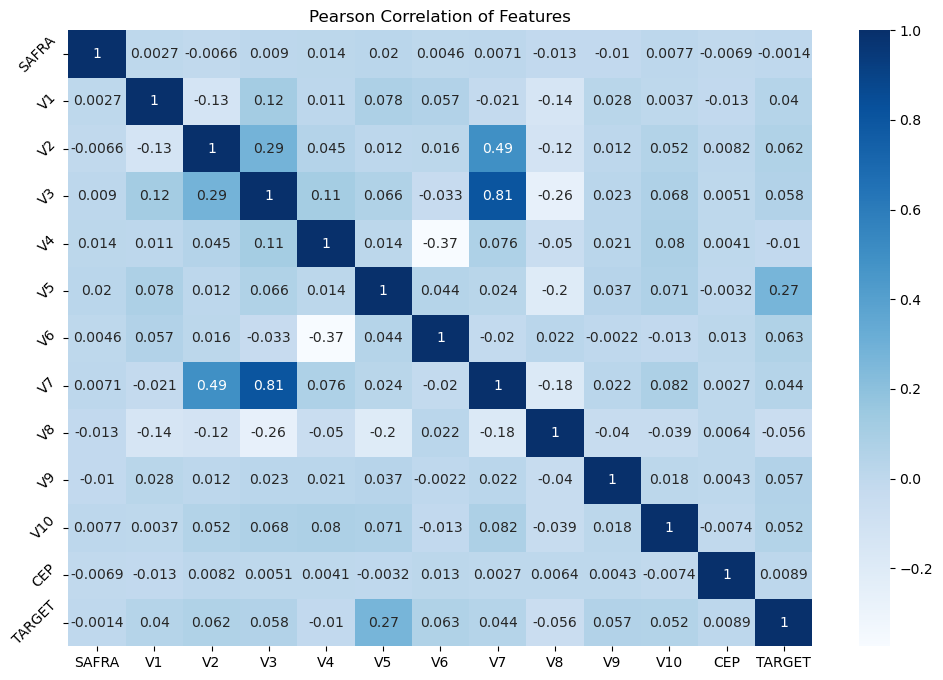

In [22]:
import seaborn as sns

corr = df.corr(numeric_only=True)

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

In [23]:
df[df.isnull().T.any()]

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,CEP,TARGET
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,0,SP,São Paulo,8412006,0
5,201910,0.0,1.7,188.00,1303,NaN,0,459.39,0.0,0.0,0,MG,Juiz de Fora,36080330,0
6,201905,0.0,100.0,105.00,0,0.0,1,1331.67,NaN,0.0,0,SP,São Paulo,8412006,0
12,201906,1.0,10.0,970.00,2223,NaN,0,3800.18,0.0,0.0,0,SP,Guarulhos,7095080,0
13,201902,NaN,65.6,212.00,2113,0.0,0,1944.09,0.0,0.0,0,SP,Campinas,13070079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11137,201909,NaN,5.0,1410.77,10824,0.0,0,5457.19,0.0,0.0,0,RJ,Rio de Janeiro,21321090,0
11139,201906,0.0,27.8,21.99,1077,NaN,0,56.57,1.0,0.0,0,SP,São Paulo,8412006,0
11155,201902,NaN,36.0,305.00,0,0.0,1,1570.78,1.0,0.0,0,ES,Vitória,29072305,0
11162,201908,0.0,3.2,84.99,223,NaN,0,181.75,1.0,0.0,0,MG,Uberaba,38080025,0


In [24]:
df[df.isin([np.inf, -np.inf]).T.any()]

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,CEP,TARGET


In [25]:
raw_shape = df.shape[0]
df = df.dropna()
df.shape[0]/raw_shape

0.7948786820664339

### Feature engineering

1. Regarding outliers in the dataset, as a first approach I took out the extreme values from float64 features and replacing them by the 3rd standart deviation value of the feature distribution.
    All values are positive, so I did removed the extremes at the start of the interval. This brought no improvement att all in this specific case, then I removed it from the analysis.

2. I gave a try to relative frequencies for each city. Same to ZIP codes. My expectation was that it could encode information from the variables keeping the feature set size controled. Again, no improvement was found and a cut it off.

In [26]:
df['month'] = df.SAFRA.astype('str').str[4:6]
df['month'] = df.month

df = pd.concat([df, pd.get_dummies(df.V11, prefix='UF')], axis=1)
df = pd.concat([df, pd.get_dummies(df.V12, prefix='city')], axis=1)
df = pd.concat([df, pd.get_dummies(df.CEP, prefix='zip')], axis=1)
df = pd.concat([df, pd.get_dummies(df.month, prefix='month')], axis=1)

3. The dataset looks like a classification problem dataset (perhaps a yes/no to some thresould of risk?). That being said, I checked about the seasonality across the cohorts. Since the meaning of other variables were not known, I analysed only the TARGET frequency across the SAFRA. From the 12 cohorts in 2019, we can see an average total of 740 observations with 8 true labels, or approximatelly 1% from the total. It means that the class is unbalanced and the issue needs to be addressed with some rebalancing technique. In this case, given the small frequency of the ones, I will approach the problem by oversampling the ones until classes are 1:1 proportional. Here I did all the work with SMOTE package

In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

features = df.columns.drop(['TARGET', 'V11', 'V12', 'CEP', 'SAFRA'])
df_train, df_test = train_test_split(df, test_size=0.30, stratify=df['TARGET'], random_state=654321)

smote = SMOTE(random_state=654321, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(df_train[features], df_train['TARGET'])

X_train_std = X_resampled
y_train = y_resampled

y_test = df_test.TARGET.astype('int')
X_test = df_test[features]

### Model choice and final remarks 

    
    At this point, I added a lot more features then the original ones looking for extract all info in the data. Lets check if there are features more important than others and keep the ones with highest impact in the metric. In this case, the choosen metric was the F1. Why F1 and not accuracy or ROC? Considering that I) the dataset is unbalanced and II) we are solving a classification problem, I want a good balance between Precision and Recall. Search for a model that improves only for Accuracy for instance will lead us to undesirable results like having impressive metric values BUT underperforming in Precision/Recall.

    Moreover, training the model with Accuracy/AUC leads to overfitting. The difference between train and test metrics are high (0.99 in train to 0.86) when using F1 the metrics differ for 0.01. 
    
    Finally, I tryied RandomForest and XGBoost models, with high level of overfitting and no improvement in the same metrics. 
    

__The final choice is the Logistic Regression for sake of simplicity with a reduced feature set of size of 6 in order to keep the model "lean". Also, Logistic Regression is "explainable" no requiring aditional techniques to explore the features weights for instance.__
    
    Below, the results and model's training metrics performed.

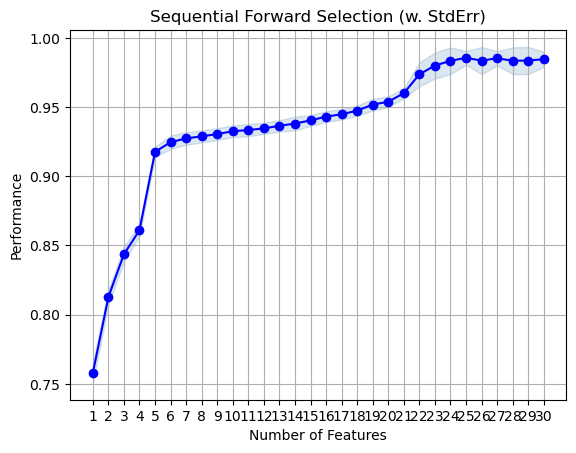

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression


selector = SFS(LogisticRegression(random_state=654321, solver='liblinear'), 
           k_features=30, 
           forward=True, 
           verbose=0,
           scoring='f1',
           cv=5, 
           n_jobs=-1)
sfs = selector.fit(X_train_std, y_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [31]:
best_feats = list(sfs.subsets_[6]['feature_names'])
best_feats

['V3', 'V5', 'UF_ES', 'UF_MG', 'UF_RJ', 'UF_SP']

#### Retaining only 5 best features

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


best_feats = list(sfs.subsets_[6]['feature_names'])
clf = LogisticRegression(random_state=654321, solver='liblinear')
clf.fit(X_train_std[best_feats], y_train)
y_pred = clf.predict(X_test[best_feats])

print("ROC = %f, F1 = %f " % (roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)))

ROC = 0.605130, F1 = 0.118644 


In [33]:
clf = LogisticRegression(random_state=654321, solver='liblinear')
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test)

print("ROC = %f, F1 = %f " % (roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)))

ROC = 0.568017, F1 = 0.210526 


#### Retaining only the 25 best features

In [34]:
best_feats = list(sfs.subsets_[25]['feature_names'])
clf = LogisticRegression(random_state=654321, solver='liblinear')
clf.fit(X_train_std[best_feats], y_train)
y_pred = clf.predict(X_test[best_feats])

print("ROC = %f, F1 = %f " % (roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)))

ROC = 0.565929, F1 = 0.163265 


In [36]:
clf = LogisticRegression(random_state=654321, solver='liblinear')
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test)

print("ROC = %f, F1 = %f " % (roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)))

ROC = 0.568017, F1 = 0.210526 


#### Testing different scoring methods

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

best_feats = list(sfs.subsets_[25]['feature_names'])

clf = LogisticRegressionCV(solver='liblinear',  cv=5, scoring='f1', random_state=654321).fit(X_train_std[best_feats], y_train)
clf.predict(X_test[best_feats])
y_pred = clf.predict(X_test[best_feats])

print('Relatório de classificação:\n', classification_report(y_test, y_pred, digits=2))

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2635
           1       0.60      0.10      0.18        29

    accuracy                           0.99      2664
   macro avg       0.80      0.55      0.59      2664
weighted avg       0.99      0.99      0.99      2664



In [40]:
clf = LogisticRegressionCV(solver='liblinear',  cv=5, scoring='precision', random_state=654321).fit(X_train_std[best_feats], y_train)
clf.predict(X_test[best_feats])
y_pred = clf.predict(X_test[best_feats])

print('Relatório de classificação:\n', classification_report(y_test, y_pred, digits=2))

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2635
           1       0.60      0.10      0.18        29

    accuracy                           0.99      2664
   macro avg       0.80      0.55      0.59      2664
weighted avg       0.99      0.99      0.99      2664



In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

clf = LogisticRegressionCV(solver='liblinear',  cv=5, scoring='recall', random_state=654321).fit(X_train_std[best_feats], y_train)
clf.predict(X_test[best_feats])
y_pred = clf.predict(X_test[best_feats])

print('Relatório de classificação:\n', classification_report(y_test, y_pred, digits=2))

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2635
           1       0.60      0.10      0.18        29

    accuracy                           0.99      2664
   macro avg       0.80      0.55      0.59      2664
weighted avg       0.99      0.99      0.99      2664

